# Inference in Pyro

In this notebook I work through the tutorial "Inference in Pyro: From Stochastic Functions to Marginal Distributions" (http://pyro.ai/examples/intro_part_ii.html) making notes as I go.

In [29]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

The following seems to be a model of a noisy measurement of a weight, with mean 'guess' and variance 1.

In [30]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", 
                         dist.normal, 
                         guess, 
                         Variable(torch.ones(1)))
    
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    x = pyro.sample("measurement", 
                       dist.normal, 
                       weight, 
                       Variable(torch.Tensor([0.75])))
    
    #print weight, x
    return x

There's an important-sounding but unexplained piece of terminology used in the tutorial here: 'execution trace'. My guess is that an execution trace is a full run through the model from the root nodes (typically the prior), simulating each variable in turn.

E.g. for the model above, the trace goes:
'guess' (deterministic) -> weight -> measurement

In [38]:
posterior = pyro.infer.Importance(scale, num_samples=200)

So I've modified the stochastic function above to print values when called, and calling posterior doesn't seem to call the function yet.

In [39]:
guess = Variable(torch.Tensor([8.5]))

marginal = pyro.infer.Marginal(posterior)
print marginal(guess)

Variable containing:
 8.2024
[torch.FloatTensor of size 1]



So a few useful notes from this:
- The posterior object (and presumably anything created in the same way) isn't changed when you change the function that's gone into it. So if I call posterior with scale, then change the code inside scale, the posterior won't change. Thus when I call marginal(guess) the old code is being used.
- The stochastic function inside marginal is only used when marginal is called, not when it's created.

100


Text(0,0.5,u'#')

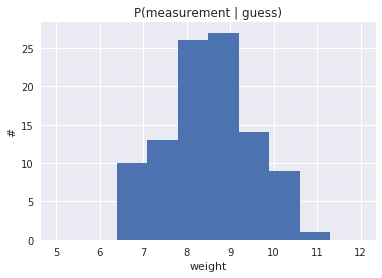

In [40]:
y = [marginal(guess).data[0] for _ in range(100)]
print len(y)

plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))

plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

So posterior is _actually_ a histogram! This is strange. We generate some fixed number of samples, set when posterior is created. We can then resample this as much as we like but will never generate more samples.

## Conditioning on data

In [41]:
conditioned_scale = pyro.condition(scale, 
                                   data={"measurement": Variable(torch.Tensor([8.5]))})